In [57]:
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np

class MnistDataset(Dataset):

    # read csv
    def __init__(self,file_path):
        super().__init__()
        self.train_data = pd.read_csv(file_path,header=None)
        self.train_data = self.train_data.to_numpy()
    def __len__(self):
        return len(self.train_data)
    def __getitem__(self, index):
        label = self.train_data[index,0]
        boolean_indexing = np.zeros((10)) #이거 왜 (label.shape[0],10)을 못하지? 이렇게 하려면 batchsize>1이라는 암묵적약속?
        boolean_indexing[label] = 1.

        return torch.FloatTensor(self.train_data[index,1:]/255),torch.FloatTensor(boolean_indexing)
        
    def plot_image(self,n):
        data = self.train_data[n,1:].reshape(28,28)
        plt.figure(figsize=(3,3))
        plt.imshow(data)



In [58]:
mnist_dataset=MnistDataset("mnist_train.csv")


In [29]:
a = torch.tensor([1,2,3,4])
b = torch.tensor([11,22])
torch.concat((a,b))


tensor([ 1,  2,  3,  4, 11, 22])

In [102]:
from torch.optim import SGD,Adam
from torch.nn import MSELoss,BCELoss

class D(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(784+10,200),
            torch.nn.LeakyReLU(0.02),
            torch.nn.LayerNorm(200),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )
        self.optimizer = Adam(self.parameters(),lr=0.0001)
        self.loss_fn = BCELoss()
        self.loss_hist = []

        self.iter = 0
    def forward(self,x):
        return self.model(x)

    def train(self,x,onehot,label):
        self.optimizer.zero_grad()
        y_pred = self.model(torch.concat((x,onehot)))
        loss = self.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()

        self.loss_hist.append(loss.item())
        self.iter+=1
        if self.iter%(100)==0:
            print(f"i {self.iter}")   
            print(f'd loss {self.loss_hist[-1]}')
    
    def visualize(self):
        plt.figure(figsize=(4,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('discriminator loss')
        plt.show()    
        


In [122]:
def gen_random(size):
    return torch.randn(size)
def gen_random_one_hot():
    zeros = torch.zeros(10)
    label = torch.randint(0,10,(1,))
    zeros[label]=1.0
    return torch.FloatTensor(zeros)
def gen_onehot(label):
    zeros = torch.zeros(10)
    zeros[label]=1.0
    return torch.FloatTensor(zeros)

In [104]:
class G(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(100+10,200),
            torch.nn.LeakyReLU(0.02),
            torch.nn.LayerNorm(200),
            torch.nn.Linear(200,784),
            torch.nn.Sigmoid(),
        )

        self.optimizer = Adam(self.parameters(),lr=0.0001)
        
        self.loss_hist = []
        self.iter=0
    def forward(self,x):
        return self.model(x)
    
    def train(self,D,x,onehot,label):
        self.optimizer.zero_grad()
        fake_pred = self.forward(torch.concat((x,onehot)))
        y_pred = D(torch.concat((fake_pred,onehot)))
        loss = D.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()
        
        self.loss_hist.append(loss.item())
        
        self.iter+=1
        if self.iter%(100)==0:

            print(f'g loss {self.loss_hist[-1]}')    
    def visualize(self):
        plt.figure(figsize=(4,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('generator loss')
        plt.show()
    
    def visualize_8img(self,x):
        fake_pred = self.forward(x).detach().numpy() # size(16,28*28)
        fake_pred = fake_pred.reshape((-1,28,28)).transpose((1,0,2)).reshape((28,-1))

        plt.figure(figsize=(16,2))
        plt.title('generator prediction')
        plt.imshow(fake_pred, cmap='Blues')
        

In [124]:
dataloader = DataLoader(mnist_dataset,1)
d = D()
g= G()



for data,onehot in dataloader: #왜 60000에서 안 멈추지?
    d.train(data.reshape(784),onehot.reshape(10),torch.tensor([1.0],dtype=torch.float32))
    ran_onehot = gen_random_one_hot()
    d.train(g(torch.concat((gen_random(100),ran_onehot))).detach(),ran_onehot,torch.tensor([0.0],dtype=torch.float32))
    g.train(d,gen_random(100),gen_random_one_hot(),torch.tensor([1.0],dtype=torch.float32))



i 100
d loss 0.00705291610211134
i 200
d loss 0.00582618685439229
g loss 5.721405982971191
i 300
d loss 0.0018355397041887045
i 400
d loss 0.001696295919828117
g loss 6.364311218261719
i 500
d loss 0.0015659666387364268
i 600
d loss 0.0012872752267867327
g loss 7.21752405166626
i 700
d loss 0.0006580132758244872
i 800
d loss 0.00047546005225740373
g loss 6.428637981414795
i 900
d loss 0.0019709805492311716
i 1000
d loss 0.0005528070614673197
g loss 6.311585426330566
i 1100
d loss 0.0013350811786949635
i 1200
d loss 0.0005910354666411877
g loss 7.633607387542725
i 1300
d loss 0.001270146807655692
i 1400
d loss 0.0006053491379134357
g loss 7.756377696990967
i 1500
d loss 0.00044916223851032555
i 1600
d loss 0.0003536969015840441
g loss 7.490845203399658
i 1700
d loss 0.000505813688505441
i 1800
d loss 0.0003017046255990863
g loss 7.810323238372803
i 1900
d loss 0.0004915014724247158
i 2000
d loss 0.00037271768087521195
g loss 7.890192031860352
i 2100
d loss 0.0005204839981161058
i 2200
d

In [141]:
epochs=6
for i in range(epochs):
    for data,onehot in dataloader:
        d.train(data.reshape(784),onehot.reshape(10),torch.tensor([1.0],dtype=torch.float32))
        ran_onehot = gen_random_one_hot()
        d.train(g(torch.concat((gen_random(100),ran_onehot))).detach(),ran_onehot,torch.tensor([0.0],dtype=torch.float32))
        g.train(d,gen_random(100),gen_random_one_hot(),torch.tensor([1.0],dtype=torch.float32))

i 120100
d loss 0.0004542905662674457
i 120200
d loss 0.00606962526217103
g loss 1.6661391258239746
i 120300
d loss 1.2600109577178955
i 120400
d loss 0.012470914050936699
g loss 0.7442957758903503
i 120500
d loss 0.005541990511119366
i 120600
d loss 0.01599755510687828
g loss 3.2035703659057617
i 120700
d loss 0.08773330599069595
i 120800
d loss 0.8918136954307556
g loss 0.4648391902446747
i 120900
d loss 0.17920370399951935
i 121000
d loss 0.12000327557325363
g loss 6.387864589691162
i 121100
d loss 0.008014462888240814
i 121200
d loss 0.038449279963970184
g loss 6.352856636047363
i 121300
d loss 0.004172314889729023
i 121400
d loss 0.30359289050102234
g loss 3.0504822731018066
i 121500
d loss 0.004804631229490042
i 121600
d loss 0.001065583317540586
g loss 1.7938565015792847
i 121700
d loss 0.0021336174104362726
i 121800
d loss 0.007708560675382614
g loss 1.513514518737793
i 121900
d loss 0.01601838879287243
i 122000
d loss 0.0019140071235597134
g loss 2.159837245941162
i 122100
d l

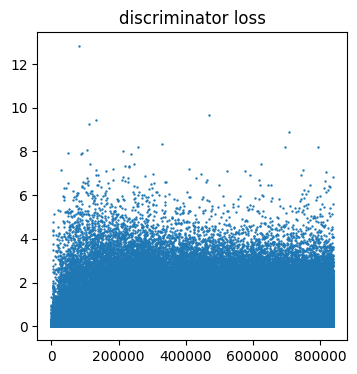

In [142]:
d.visualize()

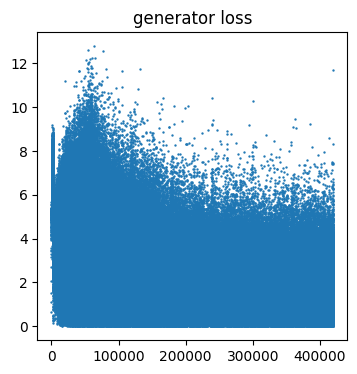

In [143]:
g.visualize()

In [127]:
def gen_onehot8(label,size):
    zeros = torch.zeros((size,10))
    zeros[:,label]=1.0
    return torch.FloatTensor(zeros)

In [128]:
gen_onehot8(1,8)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

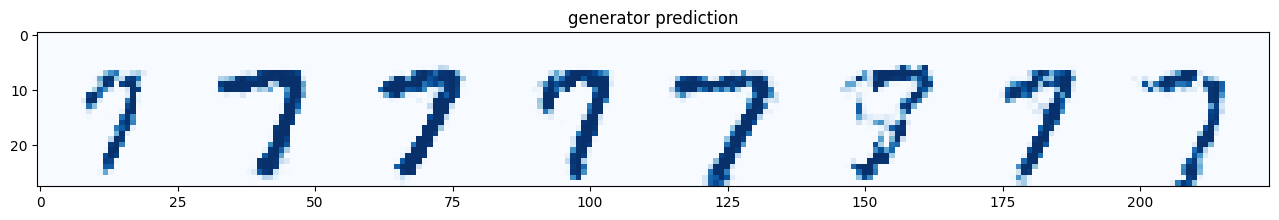

In [157]:
g.visualize_8img(torch.concat((gen_random((8,100)),\
    gen_onehot8(7,8)),dim=1)
)

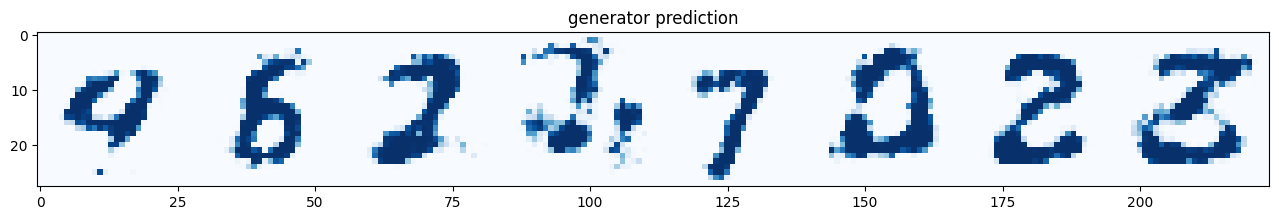

In [145]:
g.visualize_8img(gen_random((8,110)))